In [107]:
import numpy as np
from scipy.special import gammaln
from scipy.stats import binom, beta, poisson
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [27]:
red = '#FF6711'
blue = '#1160FF'

In [14]:
def generate_cohort(N, lamb, a, b):
    n = poisson.rvs(lamb, size=N)
    p = beta.rvs(a, b, size=N)
    k = []
    for ni, pi in zip(n, p):
        k.append(binom.rvs(ni, pi))
    k = np.array(k)
    return n, p, k

In [159]:
def plot_stacked_bars(k, n, labels):
    plt.figure(figsize=(8,5))
    w = 0.02
    pobs = k.astype(float)/n
    plt.bar(pobs, k, bottom=0, width=w, color=blue, zorder=2, label=labels[0])
    plt.bar(pobs, (n - k), bottom=k, width=w, color=red, zorder=2, label=labels[1])
    plt.xlim([-0.05, 1.05])
    plt.grid(zorder=1)
    return plt.gca()

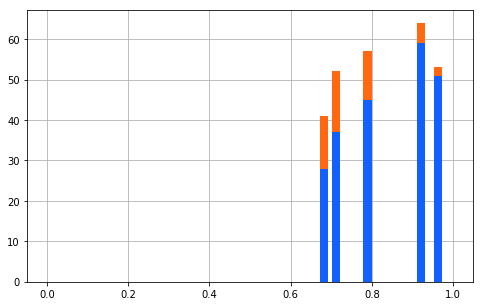

In [257]:
N1 = 5
lamb1 = 50
a1, b1 = 20, 4
n1, p1, k1 = generate_cohort(N1, lamb1, a1, b1)
plot_stacked_bars(k1, n1, [None]*2)

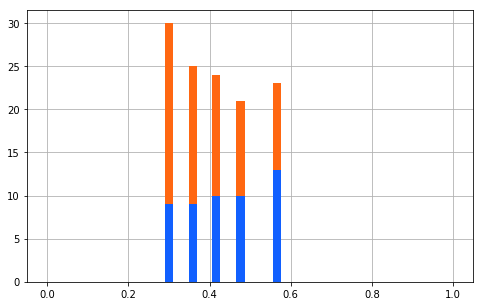

In [260]:
N2 = 5
lamb2 = 20
a2, b2 = 12, 12
n2, p2, k2 = generate_cohort(N2, lamb2, a2, b2)
plot_stacked_bars(k2, n2, [None]*2)

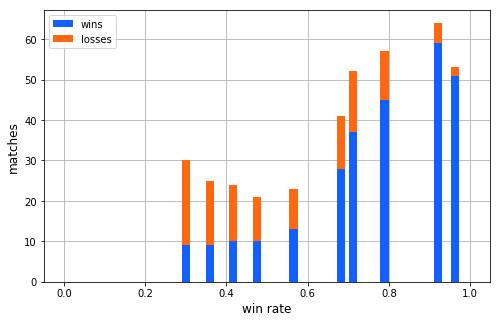

In [284]:
k = np.concatenate([k1, k2])
n = np.concatenate([n1, n2])
ax = plot_stacked_bars(k, n, ['wins', 'losses'])
ax.set_xlabel('win rate', fontsize=12)
ax.set_ylabel('matches', fontsize=12)
plt.legend()
plt.savefig('./04-betabinom-data.pdf', bbox_inches='tight')
plt.show()

In [262]:
def log_three_gamma_term(k, a):
    return gammaln(k+a) - gammaln(k+1) - gammaln(a)

def log_beta_binom(k, n, a, b):
    target = 0
    target += - log_three_gamma_term(n, a+b)
    target += log_three_gamma_term(k, a)
    target += log_three_gamma_term(n-k, b)
    return target

def log_likelihood(k, n, a, b):
    target = 0
    for ki, ni in zip(k, n):
        target += log_beta_binom(ki, ni, a, b)
    return target

In [289]:
k, n

(array([51, 28, 37, 59, 45, 10, 13,  9, 10,  9]),
 array([53, 41, 52, 64, 57, 24, 23, 30, 21, 25]))

In [264]:
a_arr, b_arr = np.meshgrid(np.linspace(0.1, 20, 100), 
                           np.linspace(0.1, 20, 100))
a_arr = a_arr.flatten()
b_arr = b_arr.flatten()

loglike = []
for a, b in zip(a_arr, b_arr):
    loglike.append(log_likelihood(k, n, a, b))
    
df = pd.DataFrame({
    'a': a_arr,
    'b': b_arr,
    'loglike': loglike
})

df['pstar'] = np.exp(df['loglike'] - df['loglike'].max())
Z = df['pstar'].sum()
df['posterior'] = df['pstar'] / Z

post_a = df.groupby(by='a')['posterior'].sum().reset_index()
post_b = df.groupby(by='b')['posterior'].sum().reset_index()

a_mean = (post_a['posterior'] * post_a['a']).sum()
b_mean = (post_b['posterior'] * post_b['b']).sum()


In [283]:
a_mean, b_mean

(4.142096427382413, 2.289393593495119)

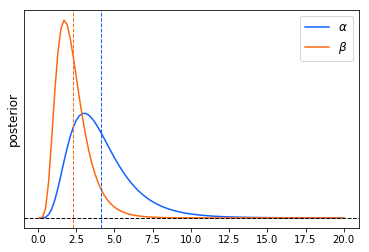

In [288]:
post_a = df.groupby(by='a')['posterior'].sum().reset_index()
post_b = df.groupby(by='b')['posterior'].sum().reset_index()
a_mean = (post_a['posterior'] * post_a['a']).sum()
b_mean = (post_b['posterior'] * post_b['b']).sum()

plt.plot(post_a['a'], post_a['posterior'], color=blue, label=r'$\alpha$')
plt.plot(post_b['b'], post_b['posterior'], color=red, label=r'$\beta$')
plt.axvline(a_mean, color=blue, lw=1, ls='--')
plt.axvline(b_mean, color=red, lw=1, ls='--')
plt.legend(fontsize=12)
plt.ylabel('posterior', fontsize=12)
ax = plt.gca()
ax.get_yaxis().set_ticks([])
plt.axhline(0, lw=1, ls='--', color='k')
plt.savefig('./04-betabinom-ab.pdf', bbox_inches='tight')
plt.show()

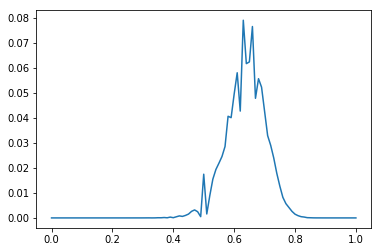

In [273]:
df['p'] = round(df['a'] / (df['a'] + df['b']), 2)
plt.plot(df.groupby(by='p')['posterior'].sum())

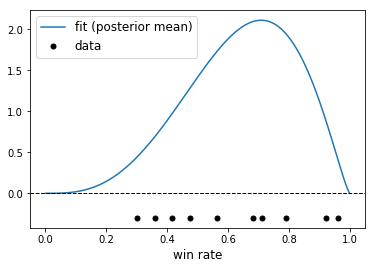

In [286]:
x_draw = np.linspace(0, 1, 1000)
plt.plot(x_draw, beta.pdf(x_draw, a_mean, b_mean), 
         label='fit (posterior mean)')
plt.axhline(0, lw=1, ls='--', color='k')
plt.plot(np.array(k).astype(float) / np.array(n), [-0.3]*len(k), 
         '.', ms=10, color='k', 
         label='data')
plt.xlabel('win rate', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('./04-betabinom-fit.pdf', bbox_inches='tight')
plt.show()